In [1]:
import datastore

import pandas as pd
import matplotlib.pyplot as plt

spot = datastore.getSpotPrice()

cons_gwh = datastore.getConsumptionGWh()

nuclear_finland_germany_mwh = datastore.getHourlyProduction_nuclear_EU()
germany_all = datastore.getHourlyProduction_Germany_all()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

hydroReservoirs = datastore.getWeeklyHydroReservs()

temp_pen = datastore.getDailyWeather()

# stationCap = datastore.getStationCap_forecast()
# transTo = datastore.getTransmissionCapTo_forecast()
# transFrom = datastore.getTransmissionCapFrom_forecast()

# productionCap = datastore.getProductionCap_forecast()


Missing values in Index(['spotPrice'], dtype='object') : 6
Missing values in Index(['ConsumptionSE1GWh', 'ConsumptionSE2GWh', 'ConsumptionSE3GWh',
       'ConsumptionSE4GWh'],
      dtype='object') : 36
Missing values in Index(['nucFI(MWh)', 'nucDE(MWh)'], dtype='object') : 1010
Missing values in Index(['wind(Mwh)', 'solar(Mwh)', 'trm(Mwh)', 'biomass(Mwh)', 'coal(MWh)',
       'gas(MWh)', 'oil(MWh)', 'lignite(MWh)', 'nuc(MWh)', 'pump(MWh)',
       'other(MWh)', 'waste(MWh)'],
      dtype='object') : 1343
Missing values in Index(['waterSE1(MWh)', 'windSE1(MWh)', 'trmSE1MWh'], dtype='object') : 145
Missing values in Index(['waterSE2(MWh)', 'windSE2(MWh)', 'solSE2MWh', 'trmSE2MWh', 'OthSE2MWh'], dtype='object') : 339
Missing values in Index(['waterSE3(MWh)', 'windSE3(MWh)', 'nucSE3(MWh)', 'solSE3MWh',
       'trmSE3MWh', 'OthSE3MWh'],
      dtype='object') : 382
Missing values in Index(['waterSE4(MWh)', 'windSE4(MWh)', 'solSE4MWh', 'trmSE4MWh', 'OthSE4MWh'], dtype='object') : 350
Missing 

: 

In [32]:
import calendar_features as cf

dataset = pd.concat([spot, cons_gwh, production_se1_mwh, production_se2_mwh, 
                                    production_se3_mwh, production_se4_mwh, temp_pen, hydroReservoirs], axis=1)
dataset.interpolate(method = 'linear', limit_direction = 'forward', inplace=True, axis=0)

daylight_features = cf.daylight_extractor(dataset)
holiday_features = cf.get_holidays(dataset)
dataset = cf.calendar_transformer(dataset)

dataset = pd.concat([dataset, daylight_features, holiday_features], axis=1)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54144 entries, 2018-01-01 00:00:00 to 2024-03-05 23:00:00
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   spotPrice                   54144 non-null  float64
 1   ConsumptionSE1GWh           54144 non-null  float64
 2   ConsumptionSE2GWh           54144 non-null  float64
 3   ConsumptionSE3GWh           54144 non-null  float64
 4   ConsumptionSE4GWh           54144 non-null  float64
 5   waterSE1(MWh)               54144 non-null  float64
 6   windSE1(MWh)                54144 non-null  float64
 7   trmSE1MWh                   54144 non-null  float64
 8   waterSE2(MWh)               54144 non-null  float64
 9   windSE2(MWh)                54144 non-null  float64
 10  solSE2MWh                   54144 non-null  float64
 11  trmSE2MWh                   54144 non-null  float64
 12  OthSE2MWh                   54144 non-null  float64
 

In [39]:

past_cov = dataset.iloc[:, 1:28]
future_cov = dataset.iloc[:, 28:-1]
target = dataset.iloc[:,0].to_frame()

In [40]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler

train_split = int(len(dataset) * 0.7)
validation_split = int(len(dataset) * 0.85)
test_split = len(dataset)

past_cov_scaler = MinMaxScaler()
future_cov_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

past_cov_scaled = past_cov_scaler.fit_transform(past_cov)
future_cov_scaled = future_cov_scaler.fit_transform(future_cov)
target_scaled = target_scaler.fit_transform(target)
    
past_cov_train, past_cov_val = past_cov_scaled[:train_split], past_cov_scaled[train_split:validation_split]
future_cov_train, future_cov_val, future_cov_test = future_cov_scaled[:train_split], future_cov_scaled[train_split:validation_split], future_cov_scaled[validation_split:]
target_train, target_val, target_test = target_scaled[:train_split], target_scaled[train_split:validation_split], target_scaled[validation_split:]

def create_dataset(array, features):
    return np.reshape(array, (len(array), 1, features))


past_cov_train = create_dataset(past_cov_train, past_cov_train.shape[1])
future_cov_train = create_dataset(future_cov_train, future_cov_train.shape[1])
target_train = create_dataset(target_train, 1)

past_cov_val = create_dataset(past_cov_val, past_cov_val.shape[1])
future_cov_val = create_dataset(future_cov_val, future_cov_val.shape[1])
target_val = create_dataset(target_val, 1)

In [41]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Input, concatenate
from keras.utils import plot_model
from keras.optimizers import Adam


#x_train = np.reshape(x_train, (len(x_train), 1, num_features))

past_cov_input= Input(shape=(past_cov_train.shape[1], past_cov_train.shape[2]))
future_cov_input = Input(shape=(future_cov_train.shape[1], future_cov_train.shape[2]))

x1 = LSTM(8, return_sequences=True)(past_cov_input)
x1 = LSTM(8)(x1)

x2 = LSTM(8, return_sequences=True)(future_cov_input)
x2 = LSTM(8)(x2)

x = concatenate([x1, x2])
out = Dense(1)(x)

model = Model(inputs=[past_cov_input, future_cov_input], outputs=out)
model.compile(optimizer=Adam(learning_rate=0.001, amsgrad=True), loss='mean_squared_error', metrics=['mae'])

model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1, 27)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 1, 8)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ (None, 1, 8)      │      1,152 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 1, 8)      │        544 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 8)         │        544 │ lstm_24[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ (None, 8)         │        544 │ lstm_26[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 16)        │          0 │ lstm_25[0][0],    │
│ (Concatenate)       │                   │            │ lstm_27[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         17 │ concatenate_6[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', min_delta= 0, patience=5)

epochs = 30
batch_size = 32

log = model.fit(
    [past_cov_train, future_cov_train], target_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([past_cov_val, future_cov_val], target_val),
    callbacks=[callback],
    shuffle=False
)
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')


In [71]:
from keras.losses import mean_absolute_error, mean_absolute_percentage_error

y_pred = model.predict(future_cov_test)
y_pred = target_scaler.inverse_transform(y_pred)
y_val = target_scaler.inverse_transform(target_val.reshape(-1, 1))

mae =  mean_absolute_error(y_val, y_pred).numpy().mean()
mape = mean_absolute_percentage_error(y_val, y_pred).numpy().mean()
print(f'Mean Absolute Error: {mae}')
print (f'Mean Absolute Percentage Error: {mape}')
plt.figure(figsize=(17, 6))
plt.plot(y_pred, label='Predictions', linestyle='--')
plt.plot(y_val, label='Actuals')
plt.legend()
plt.show()


ValueError: Layer 'functional_13' expected 2 input(s). Received 1 instead.

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])
    data = np.array(data)
    labels = np.array(labels)
    print(data.shape ,labels.shape)
    
    return data, labels


train_split = int(len(dataset) * 0.7)
validation_split = int(len(dataset) * 0.85)
test_split = len(dataset)

featureScaler = MinMaxScaler(feature_range=(-1, 1))
targetScaler = MinMaxScaler(feature_range=(-1, 1))


In [4]:

past = 24
future = 0
step = 1

features = dataset.drop('spotPrice', axis=1)
target = dataset['spotPrice'].values.reshape(-1, 1)

x_train = featureScaler.fit_transform(features.values[:train_split])
y_train = targetScaler.fit_transform(target[:train_split])

x_val = featureScaler.transform(features.values[train_split:validation_split])
y_val = targetScaler.transform(target[train_split:validation_split])

x_test = featureScaler.transform(features.values[validation_split:test_split])
y_test = targetScaler.transform(target[validation_split:test_split])

# x_train, y_train = multivariate_data(featureScaler.fit_transform(features.values), targetScaler.fit_transform(target), 0, 
#                                      train_split, past, future, step, single_step=True)
# x_val, y_val = multivariate_data(featureScaler.fit_transform(features.values), targetScaler.fit_transform(target), train_split, validation_split, 
#                                  past, future, step, single_step=True)
# x_test, y_test = multivariate_data(featureScaler.fit_transform(features.values), targetScaler.fit_transform(target), validation_split, test_split, 
#                                    past, future, step, single_step=True)


# x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
# x_val = x_val.reshape(x_val.shape[0], 1, x_val.shape[1])
# x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

# print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(37843, 24, 36) (37843, 1)
(8090, 24, 36) (8090, 1)
(8091, 24, 36) (8091, 1)


In [110]:
import keras

model = keras.models.Sequential()


model.add(keras.layers.LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False, activation='relu'))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(24))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, amsgrad=True), loss='mse', metrics='mae')
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 50)                17400     
                                                                 
 dropout_31 (Dropout)        (None, 50)                0         
                                                                 
 dense_30 (Dense)            (None, 24)                1224      
                                                                 
Total params: 18624 (72.75 KB)
Trainable params: 18624 (72.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


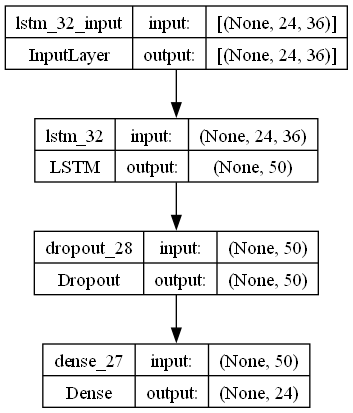

In [96]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Epoch 1/50
148/148 [==============================] - 2s 9ms/step - loss: 0.0903 - mae: 0.2002 - val_loss: 0.0968 - val_mae: 0.2068
Epoch 2/50
148/148 [==============================] - 1s 9ms/step - loss: 0.0146 - mae: 0.0921 - val_loss: 0.0888 - val_mae: 0.1925
Epoch 3/50
148/148 [==============================] - 1s 9ms/step - loss: 0.0106 - mae: 0.0781 - val_loss: 0.0858 - val_mae: 0.1867
Epoch 4/50
148/148 [==============================] - 1s 9ms/step - loss: 0.0087 - mae: 0.0709 - val_loss: 0.0786 - val_mae: 0.1813
Epoch 5/50
148/148 [==============================] - 1s 9ms/step - loss: 0.0076 - mae: 0.0661 - val_loss: 0.0777 - val_mae: 0.1794
Epoch 6/50
148/148 [==============================] - 1s 8ms/step - loss: 0.0069 - mae: 0.0630 - val_loss: 0.0780 - val_mae: 0.1785
Epoch 7/50
148/148 [==============================] - 1s 8ms/step - loss: 0.0063 - mae: 0.0597 - val_loss: 0.0707 - val_mae: 0.1741
Epoch 8/50
148/148 [==============================] - 1s 8ms/step - loss: 0.

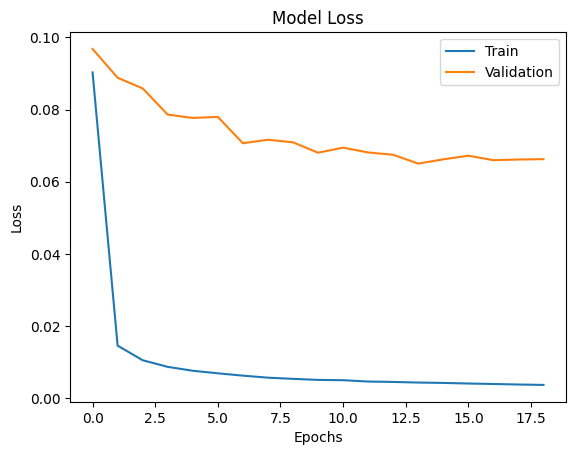

In [111]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

epochs = 50
batch_size = 256

log = model.fit(
    x_train, y_train, epochs=epochs, batch_size= batch_size, validation_data= (x_val, y_val),  callbacks=[callback]
)

plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

253/253 [==============================] - 0s 1ms/step
754.6341


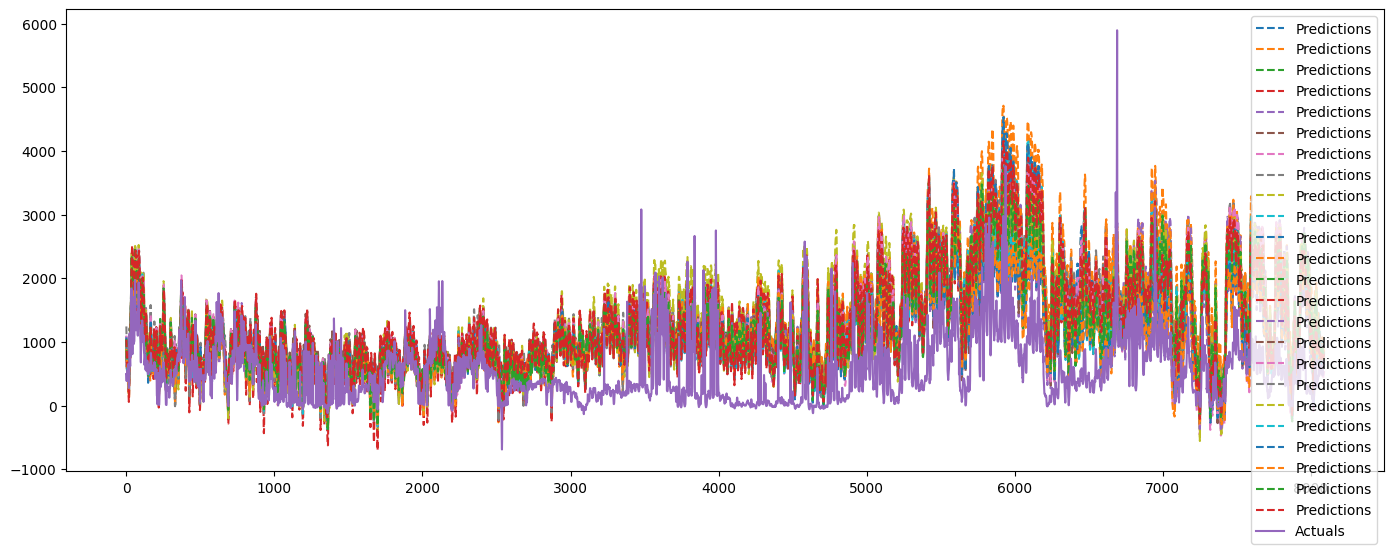

In [112]:
import matplotlib.pyplot as plt

y_pred =(model.predict(x_test))
predictions = targetScaler.inverse_transform(y_pred)
actuals = targetScaler.inverse_transform(y_test)

mae = keras.losses.MeanAbsoluteError()
print(mae(actuals, predictions).numpy())

plt.figure(figsize=(17, 6))
plt.plot(predictions, label='Predictions', linestyle='--')
plt.plot(actuals, label='Actuals')
plt.legend()
plt.show()


1153367.0